<H1 style="text-align:center"> Slots Game Performance Predictor - Sequentials Neural Network model</H1>
<H2 style="text-align:center">Model Training notebook</H2>


In this notebook we will train our sequential neural network models (Recurrent and Convolutional) to predict the success category of Slots Games based on the players' balance sequence.

# Libraries

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Bidirectional, LSTM,Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D, Flatten
from tensorflow.keras.layers import MaxPooling1D
from sklearn.preprocessing import StandardScaler
import pickle


# Load Data

In [2]:
BitMap200 = pd.read_csv('CSVFiles\\GroupedBitMap.csv')
BitMap200=BitMap200.set_index('GutsId')

BitMap1k = pd.read_csv('CSVFiles\\GroupedBitMap_1k.csv')
BitMap1k=BitMap1k.set_index('GutsId')

In [3]:
BitMap1k

,SampleId,Balance_Seq,Success,labels
GutsId,,,,
194,26432,[104.2 103.44 102.44 101.44 100.64 99.64 99...,0,0
194,216744,[99. 98.76 97.76 96.96 95.96 96.56 96.2 95....,0,0
194,216745,[ 99. 98.2 97.6 96.8 96. 97. 96...,0,1
194,216746,[ 99. 98.88 97.88 97.68 96.68 95.92 94...,0,9
194,216747,[ 99.44 98.64 99.44 98.44 97.44 98.44 97...,0,8
...,...,...,...,...
363,286923,[99. 98. 97. 97. 98.5 97.5 97.75 96....,1,0
363,286924,[99. 98. 97. 96. 98. 98. 98.25 97....,1,0
363,286925,[ 99. 98. 97. 96. 95. 94. 97...,1,7


<h1 style="text-align:center"><u> 1 - Neural Network Architectures </u></h1>

We define the functions where we initialize our convolutional and recurrent neural networks.

In [51]:
def cnn_model (IS,lr):
    model = Sequential()

    model.add(Conv1D(filters=254, kernel_size=128,  activation='relu',input_shape=(IS,1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Dropout(0.4))

    model.add(Conv1D(filters=128, kernel_size=35, activation='relu'))
    model.add(MaxPooling1D(2))


    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    opt = keras.optimizers.SGD(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

def recurrent_model(IS,lr):
    model=Sequential()
    model.add(Bidirectional(LSTM(64,return_sequences=True,activation='relu'), input_shape=(IS,1)))
    
    model.add(Bidirectional(LSTM(24,activation='relu',return_sequences=True)))
    model.add(Bidirectional(LSTM(5,activation='relu')))

    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    opt = keras.optimizers.SGD(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy'])
    
    return model
 

<h1 style="text-align:center"><u> 2 - Model Training </u></h1>
<h2 style="text-align:center"><u> 2.1 All Samples </u></h2>

First, let's train our model using all of the game sessions of each Slots Game

## 2.1.1 - Data Preparation 

### Splitting Input and Output variables
Split the input and output variables for the game sessions of 200 spins

In [58]:
#We define the game IDs that will be used to train our model
total_gut=[358,347,307,362,
           235,221,308,306]

df=BitMap200.loc[total_Gut].copy()

x_=[]
y_=[]

for i in df.index.unique():
    for j in df.loc[i]['SampleId'].unique():
        str_arr=df[(df.index == i) & (df['SampleId'] == j)]['Balance_Seq'].values[0]
        values = str_arr.replace('[', '').replace(']', '').split()
        # Convert the values to a NumPy array of float numbers  
        arr_ = np.fromstring(' '.join(values), sep=' ')  
        
        x_.append(arr_)
        y_.append(df[(df.index == i) & (df['SampleId'] == j)]['Success'].values[0])
        

Let's split now the input and output variables for the game sessions of 1000 spins.

In [59]:
df1k=BitMap1k.loc[total_Gut].copy()
# df=BitMap.copy()


x1k_=[]
y1k_=[]


for i in df1k.index.unique():
    for j in df1k.loc[i]['SampleId'].unique():
        str_arr=df1k[(df1k.index == i) & (df1k['SampleId'] == j)]['Balance_Seq'].values[0]
        values = str_arr.replace('[', '').replace(']', '').split()
        # Convert the values to a NumPy array of float numbers  
        arr_ = np.fromstring(' '.join(values), sep=' ')  
        
        x1k_.append(arr_)
        y1k_.append(df1k[(df1k.index == i) & (df1k['SampleId'] == j)]['Success'].values[0])
        

### Re Shape Data

In [61]:
# For the game sessions of 200 spins
x=np.array(x_)
y=np.array(y_)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(x)
x = scaler.transform(x)
inversed = scaler.inverse_transform(x)

x = np.reshape(x, (np.array(x).shape[0], np.array(x).shape[1], 1))

print(x.shape,'\n',y.shape)


# For the game sessions of 1000 spins

x1k=np.array(x1k_)
y1k=np.array(y1k_)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(x1k)
x1k = scaler.transform(x1k)
inversed = scaler.inverse_transform(x1k)

x1k = np.reshape(x1k, (np.array(x1k).shape[0], np.array(x1k).shape[1], 1))

print(x1k.shape,'\n',y1k.shape)

(15000, 200, 1) 
 (15000,)
(15000, 1000, 1) 
 (15000,)


## 2.1.2 Model Training

Let's train our convolutional and recurrent neural network using the data from all of the game sessions per Slots Game.

Convolutional NN for game sessions of 200 spins

In [62]:
model1=cnn_model(x[0].shape[0],0.1)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=6)

history_200=model1.fit(x,y,validation_split=0.2, epochs=100, verbose=1,callbacks=[early_stopping,rlrop])


Epoch 1/100
375/375 [==============================] - 45s 119ms/step - loss: 0.4561 - accuracy: 0.8324 - val_loss: 1.6941 - val_accuracy: 0.0000e+00 - lr: 0.1000
Epoch 2/100
375/375 [==============================] - 44s 118ms/step - loss: 0.4501 - accuracy: 0.8333 - val_loss: 1.6900 - val_accuracy: 0.0000e+00 - lr: 0.1000
Epoch 3/100
375/375 [==============================] - 45s 120ms/step - loss: 0.4459 - accuracy: 0.8338 - val_loss: 1.8453 - val_accuracy: 0.0027 - lr: 0.1000
Epoch 4/100
375/375 [==============================] - 47s 125ms/step - loss: 0.4394 - accuracy: 0.8351 - val_loss: 2.0941 - val_accuracy: 0.0130 - lr: 0.1000
Epoch 5/100
375/375 [==============================] - 47s 125ms/step - loss: 0.4339 - accuracy: 0.8360 - val_loss: 1.9363 - val_accuracy: 0.0160 - lr: 0.1000
Epoch 6/100
375/375 [==============================] - 46s 124ms/step - loss: 0.4299 - accuracy: 0.8365 - val_loss: 1.5917 - val_accuracy: 0.0210 - lr: 0.1000
Epoch 7/100
375/375 [=================

Convolutional NN for game sessions of 1000 spins

In [79]:
model_1k=cnn_model(x1k[0].shape[0],0.1)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=6)

history_1k=model_1k.fit(x1k,y1k,validation_split=0.2, epochs=100, verbose=1,callbacks=[early_stopping,rlrop])


Epoch 1/100
375/375 [==============================] - 406s 1s/step - loss: 0.4562 - accuracy: 0.8332 - val_loss: 1.6494 - val_accuracy: 0.0120 - lr: 0.1000
Epoch 2/100
375/375 [==============================] - 397s 1s/step - loss: 0.4441 - accuracy: 0.8347 - val_loss: 1.5613 - val_accuracy: 0.0263 - lr: 0.1000
Epoch 3/100
375/375 [==============================] - 398s 1s/step - loss: 0.4308 - accuracy: 0.8356 - val_loss: 1.8141 - val_accuracy: 0.0473 - lr: 0.1000
Epoch 4/100
375/375 [==============================] - 398s 1s/step - loss: 0.4258 - accuracy: 0.8355 - val_loss: 1.6041 - val_accuracy: 0.0283 - lr: 0.1000


Recurrent NN for game sessions of 200 spins

In [78]:
model1_recurrent=recurrent_model(x[0].shape[0],0.1)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=4)

history_200_recurrent=model1_recurrent.fit(x,y,validation_split=0.2, epochs=100, verbose=1,callbacks=[early_stopping,rlrop])


Epoch 1/100
375/375 [==============================] - 141s 366ms/step - loss: 0.4579 - accuracy: 0.8328 - val_loss: 1.7647 - val_accuracy: 0.0000e+00 - lr: 0.1000
Epoch 2/100
375/375 [==============================] - 132s 351ms/step - loss: 0.4514 - accuracy: 0.8333 - val_loss: 1.7919 - val_accuracy: 0.0000e+00 - lr: 0.1000
Epoch 3/100
375/375 [==============================] - 131s 351ms/step - loss: 0.4511 - accuracy: 0.8333 - val_loss: 1.7578 - val_accuracy: 0.0000e+00 - lr: 0.1000
Epoch 4/100
375/375 [==============================] - 131s 350ms/step - loss: 0.4515 - accuracy: 0.8333 - val_loss: 1.8591 - val_accuracy: 0.0000e+00 - lr: 0.1000
Epoch 5/100
375/375 [==============================] - 132s 351ms/step - loss: 0.4508 - accuracy: 0.8333 - val_loss: 1.7545 - val_accuracy: 0.0000e+00 - lr: 0.1000
Epoch 6/100
375/375 [==============================] - 128s 343ms/step - loss: 0.4514 - accuracy: 0.8333 - val_loss: 1.7560 - val_accuracy: 0.0000e+00 - lr: 0.1000
Epoch 7/100
375/

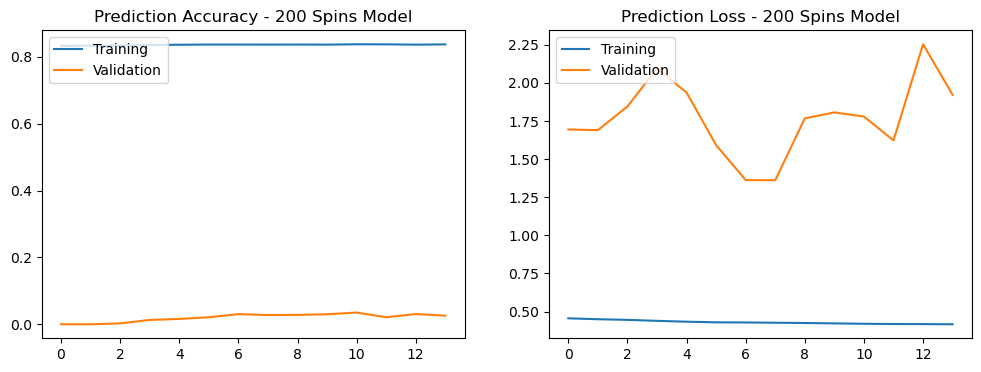

In [66]:

plt.figure(figsize=(12, 4)) 

# Plot the first plot  
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1  
plt.plot(history_200.history['accuracy'])
plt.plot(history_200.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='upper left')
plt.title('Prediction Accuracy - 200 Spins Model')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2  
plt.plot(history_200.history['loss'])
plt.plot(history_200.history['val_loss'])
plt.legend(['Training', 'Validation'], loc='upper left')
plt.title('Prediction Loss - 200 Spins Model')
plt.show()

plt.show()

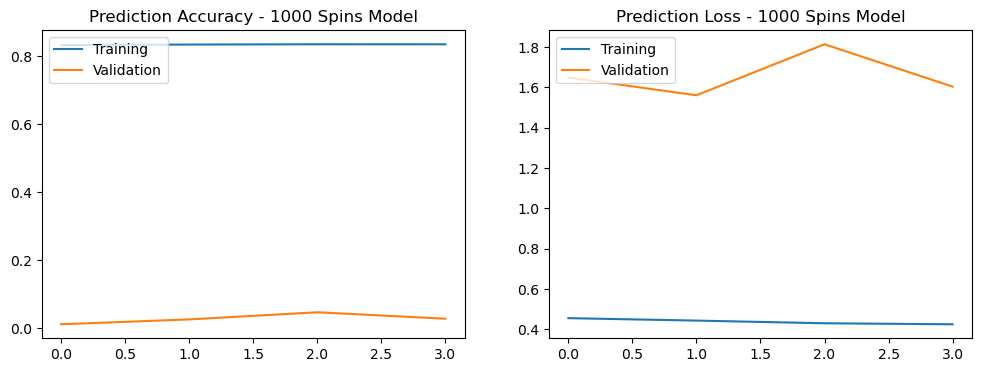

In [80]:

plt.figure(figsize=(12, 4)) 

# Plot the first plot  
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1  
plt.plot(history_1k.history['accuracy'])
plt.plot(history_1k.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='upper left')
plt.title('Prediction Accuracy - 1000 Spins Model')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2  
plt.plot(history_1k.history['loss'])
plt.plot(history_1k.history['val_loss'])
plt.legend(['Training', 'Validation'], loc='upper left')
plt.title('Prediction Loss - 1000 Spins Model')
plt.show()

plt.show()

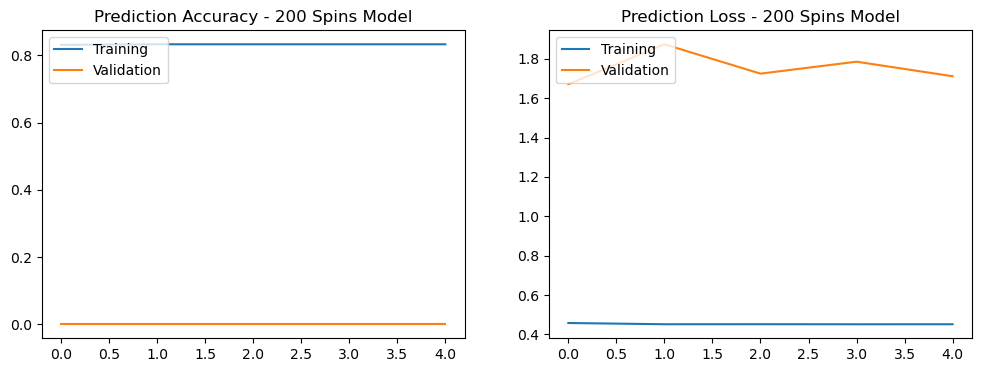

In [68]:

plt.figure(figsize=(12, 4)) 

# Plot the first plot  
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1  
plt.plot(history_200_recurrent.history['accuracy'])
plt.plot(history_200_recurrent.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='upper left')
plt.title('Prediction Accuracy - 200 Spins Model')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2  
plt.plot(history_200_recurrent.history['loss'])
plt.plot(history_200_recurrent.history['val_loss'])
plt.legend(['Training', 'Validation'], loc='upper left')
plt.title('Prediction Loss - 200 Spins Model')
plt.show()

plt.show()

As we can appreciate for the models trained over all the game sessions game sessions no convergence was achieved.

<h1 style="text-align:center"><u> 2.4 Samples Close to the Median </u></h1>

## 2.4.1 - Data Preparation

### Reading Data
Let's load the data of the game sessions that ended in the third quantile of the 

In [15]:
# #read from csv file
data_DF1000 = pd.read_csv('CSVFiles\\raw_trainingData1000.csv')
data_DF1000=data_DF1000.set_index(['GutsId'])

#read from csv file
data_DF = pd.read_csv('CSVFiles\\raw_trainingData200.csv')
data_DF=data_DF.set_index(['GutsId'])

### Data Processing Functions

In [17]:
#Extraction of median sequences
def median_sequences(df,samplesNo,total_gut, bitMap):
    #Obtain the median value for each game
    len_seq=df.groupby(['GutsId','SampleId'])['total_Balance'].count()
    median_seq=len_seq.groupby('GutsId').median()
    median_seq=len_seq.groupby(level=0).transform('median')  
    len_seq=pd.concat([len_seq.rename('seq_len'), median_seq.rename('median')], axis=1).sort_values(by=['GutsId', 'seq_len'])
    
    # Get the 100 samples closest to the median
    median_samples=[]

    for i in len_seq.loc[total_gut].index.get_level_values(0).unique():
        mask_greater=len_seq.loc[i]['seq_len']>len_seq.loc[i]['median']
        mask_lesser=len_seq.loc[i]['seq_len']<len_seq.loc[i]['median']

        # Append the samples into the median_samples list 
        for j in len_seq.loc[i][mask_lesser].tail(samplesNo).index:
            median_samples.append(j)

        for j in len_seq.loc[i][mask_greater].head(samplesNo).index:
            median_samples.append(j)

    median_BitMap=bitMap[bitMap['SampleId'].isin(median_samples)].copy()
    return median_BitMap


#Converting String to numeric values
def str_num(df):
    x_=[]
    y_=[]
    
    for i in df.index.unique():
        for j in df.loc[i]['SampleId'].unique():
            str_arr=df[(df.index == i) & (df['SampleId'] == j)]['Balance_Seq'].values[0]
            values = str_arr.replace('[', '').replace(']', '').split()
            # Convert the values to a NumPy array of float numbers  
            arr_ = np.fromstring(' '.join(values), sep=' ')  

            x_.append(arr_)
            y_.append(df[(df.index == i) & (df['SampleId'] == j)]['Success'].values[0])
    x=np.array(x_)
    y=np.array(y_)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(x)
    x = scaler.transform(x)
    x = np.reshape(x, (np.array(x).shape[0], np.array(x).shape[1], 1))
    
    return x,y
        

### Splitting Input and Output data

In [18]:
total_gut=[358,347,307,362,
           235,221,308,306]


median_BitMap=median_sequences(data_DF1000,100,total_gut,BitMap1k)
print('Number of Samples per Game Category:\n{}'.format(median_BitMap['Success'].value_counts()))

x,y=str_num(median_BitMap)


print(x.shape,'\n',y.shape)



Number of Samples per Game Category:
0    800
1    800
Name: Success, dtype: int64
(1600, 1000, 1) 
 (1600,)


## 2.4.2 Model Training

In [20]:
model_med=cnn_model(x[0].shape[0],0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=6)

history_median=model_med.fit(x,y,validation_split=0.2, epochs=100, verbose=1,callbacks=[early_stopping,rlrop])


Epoch 1/100
40/40 [==============================] - 29s 723ms/step - loss: 0.6913 - accuracy: 0.6766 - val_loss: 0.6904 - val_accuracy: 0.6187 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 27s 662ms/step - loss: 0.6830 - accuracy: 0.8750 - val_loss: 0.6818 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 25s 629ms/step - loss: 0.6734 - accuracy: 0.9430 - val_loss: 0.6701 - val_accuracy: 0.9031 - lr: 0.0010
Epoch 4/100
40/40 [==============================] - 23s 570ms/step - loss: 0.6616 - accuracy: 0.9789 - val_loss: 0.6529 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 5/100
40/40 [==============================] - 23s 583ms/step - loss: 0.6462 - accuracy: 0.9883 - val_loss: 0.6277 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 6/100
40/40 [==============================] - 23s 578ms/step - loss: 0.6254 - accuracy: 0.9945 - val_loss: 0.5871 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 7/100
40/40 [==============================] - 23s 5

Epoch 53/100
40/40 [==============================] - 22s 548ms/step - loss: 0.0209 - accuracy: 0.9969 - val_loss: 0.0049 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 54/100
40/40 [==============================] - 22s 546ms/step - loss: 0.0202 - accuracy: 0.9961 - val_loss: 0.0050 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 55/100
40/40 [==============================] - 23s 567ms/step - loss: 0.0194 - accuracy: 0.9961 - val_loss: 0.0041 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 56/100
40/40 [==============================] - 23s 575ms/step - loss: 0.0193 - accuracy: 0.9969 - val_loss: 0.0043 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 57/100
40/40 [==============================] - 22s 547ms/step - loss: 0.0182 - accuracy: 0.9969 - val_loss: 0.0044 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 58/100
40/40 [==============================] - 23s 568ms/step - loss: 0.0182 - accuracy: 0.9969 - val_loss: 0.0044 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 59/100
40/40 [==============================] 

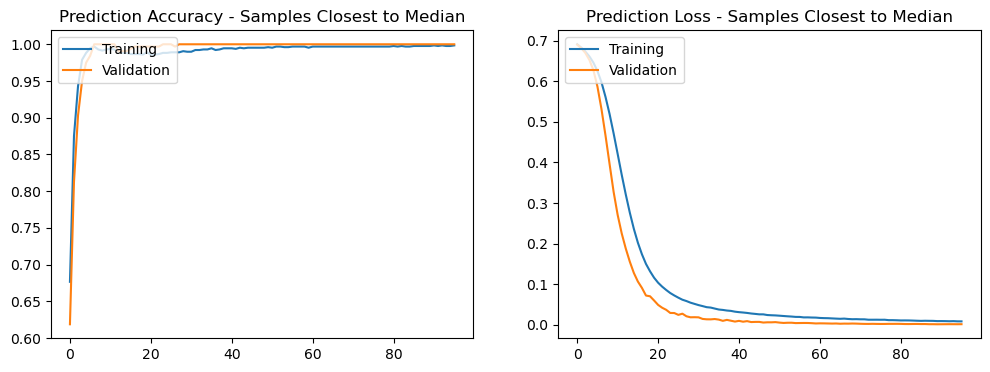

In [21]:
plt.figure(figsize=(12, 4)) 

# Plot the first plot  
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1  
plt.plot(history_median.history['accuracy'])
plt.plot(history_median.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='upper left')
plt.title('Prediction Accuracy - Samples Closest to Median')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2  
plt.plot(history_median.history['loss'])
plt.plot(history_median.history['val_loss'])
plt.legend(['Training', 'Validation'], loc='upper left')
plt.title('Prediction Loss - Samples Closest to Median')
plt.show()

plt.show()

In [55]:
model_med_recurrent=recurrent_model(x[0].shape[0],0.01)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=6)

history_median_recurrent=model_med_recurrent.fit(x,y,validation_split=0.2, epochs=100, verbose=1,callbacks=[early_stopping,rlrop])

Epoch 1/100
375/375 [==============================] - 115s 298ms/step - loss: 0.5183 - accuracy: 0.8315 - val_loss: 1.5543 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 2/100
375/375 [==============================] - 116s 310ms/step - loss: 0.4523 - accuracy: 0.8333 - val_loss: 1.7522 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 3/100
375/375 [==============================] - 115s 306ms/step - loss: 0.4507 - accuracy: 0.8333 - val_loss: 1.7818 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 4/100
375/375 [==============================] - 119s 319ms/step - loss: 0.4506 - accuracy: 0.8333 - val_loss: 1.7900 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 5/100
375/375 [==============================] - 110s 295ms/step - loss: 0.4506 - accuracy: 0.8333 - val_loss: 1.8054 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 6/100
375/375 [==============================] - 114s 305ms/step - loss: 0.4506 - accuracy: 0.8333 - val_loss: 1.7954 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 7/100
375/

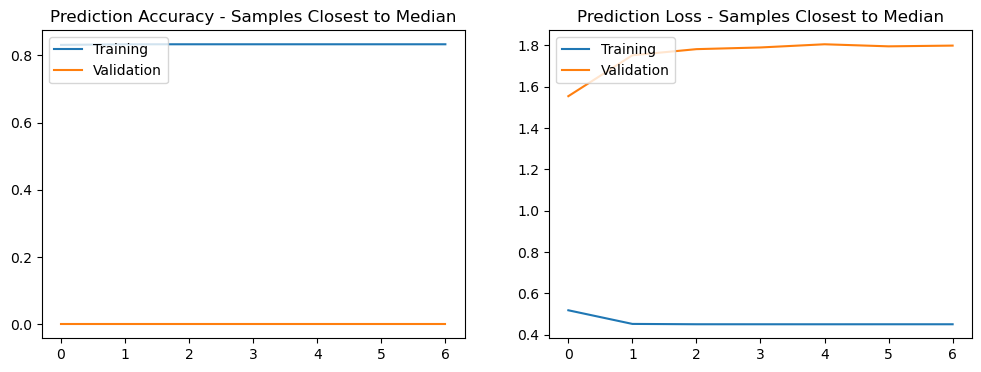

In [57]:
plt.figure(figsize=(12, 4)) 

# Plot the first plot  
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1  
plt.plot(history_median_recurrent.history['accuracy'])
plt.plot(history_median_recurrent.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='upper left')
plt.title('Prediction Accuracy - Samples Closest to Median')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2  
plt.plot(history_median_recurrent.history['loss'])
plt.plot(history_median_recurrent.history['val_loss'])
plt.legend(['Training', 'Validation'], loc='upper left')
plt.title('Prediction Loss - Samples Closest to Median')
plt.show()

plt.show()

<h1 style="text-align:center"><u> 3 - Model Testing </u></h1>



Now let's test the models on data from games that hasn't seen before.



## 3.1 - CNN model trained over all the game sessions of each Slots Game
### 3.1.1 - Prepare  & Reshape Data

Load the data of all the 200-spins game sessions for games never seen before.

In [75]:
BitMapTest200 = pd.read_csv('CSVFiles\\BitMap_Test200.csv')
BitMapTest200=BitMapTest200.set_index('Unnamed: 0')
BitMapTest200=BitMapTest200.rename_axis('GutsId')
display(BitMapTest200)

dfTest=pd.concat([BitMapTest200,BitMap200.loc[[299, 362, 363,194, 227, 228, 236, 237, 238,
                                          239, 245, 249, 252, 259,290]]]).copy()

print('Number of Samples per Game Category:\n{}'.format(dfTest['Success'].value_counts()))
xtest,ytest=str_num(dfTest)

print(xtest.shape,'\n',ytest.shape)


,SampleId,Balance_Seq,Success
GutsId,,,
191,219671,[100. 99. 100. 99.33 98.33 97.33 96...,1
191,219672,[ 99.17 98.17 97.33 96.33 95.33 94.33 93...,1
191,219673,[ 99. 98. 97. 100.17 113.43 112.67 111...,1
191,219674,[103.17 102.17 102.17 101.17 100.17 100.17 99...,1
191,219675,[99. 98. 97.83 98.07 98.07 97.07 96.07 96....,1
...,...,...,...
351,12009,[ 99. 98.4 97.4 96.4 95.4 94.4 93.4 92...,0
351,12010,[99. 98. 97. 96. 95. 94. 93.6 93. 92. ...,0
351,12011,[ 99.4 98.4 97.4 101. 100.8 100.2 99.2 98...,0


Number of Samples per Game Category:
1    18000
0    18000
Name: Success, dtype: int64
(34000, 200, 1) 
 (34000,)


### 3.1.2 - Test model

In [76]:
y_unseen_predict200=np.round(model1.predict(xtest))

1063/1063 [==============================] - 23s 22ms/step


Successful Games acc:  71.0 %
Unsuccessful Games acc:  30.0 %


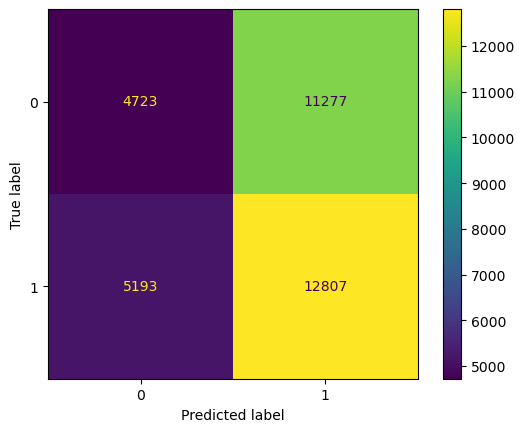

In [77]:
results_unseen200 = confusion_matrix(ytest, y_unseen_predict200)
s_acc_u200=results_unseen200[1][1]/sum(results_unseen200[1])
u_acc_u200=results_unseen200[0][0]/sum(results_unseen200[0])
print('Successful Games acc: ',np.round(s_acc_u200*100),'%')
print('Unsuccessful Games acc: ',np.round(u_acc_u200*100),'%')
cm_display_u200 = ConfusionMatrixDisplay(results_unseen200).plot()

We can appreciate how the model didn't learn to generalize and it tends to classify all of the game sessions as the 'successful' category.

## 3.2 - CNN model trained over the game sessions closer to the median sequence

### 3.2.2 Load & Reshape Data

In [44]:
#read from csv file
data_DF1KTest = pd.read_csv('CSVFiles\\raw_testingData1K.csv')
data_DF1KTest=data_DF1KTest.set_index(['GutsId'])
data_DF1KTest.index.unique()

Int64Index([191, 197, 220, 224, 227, 232, 259, 272, 316, 319, 341, 351], dtype='int64', name='GutsId')

In [45]:
dfTest_med=pd.concat([data_DF1KTest,data_DF1000])

In [46]:
total_gutT=total_gutT=[191, 197, 220, 224, 227, 232, 259, 316, 319, 341, 351,
                       250, 254, 268, 299, 362, 363,194, 228, 236, 237, 238, 239]
dfTest=pd.concat([BitMapTest,BitMap1k]).copy()
# dfTest=BitMapTest.copy()
median_BitMapTest=median_sequences(dfTest_med,100,total_gutT,dfTest)
print('Number of Samples per Game Category:\n{}'.format(median_BitMapTest['Success'].value_counts()))

xtest_med,ytest_med=str_num(median_BitMapTest)
print(xtest_med.shape,'\n',ytest_med.shape)

Number of Samples per Game Category:
0    2800
1    2200
Name: Success, dtype: int64
(4600, 1000, 1) 
 (4600,)


In [47]:
y_unseen_predict_med=np.round(model_med.predict(xtest_med))

144/144 [==============================] - 38s 266ms/step


Successful Games acc:  70.0 %
Unsuccessful Games acc:  59.0 %


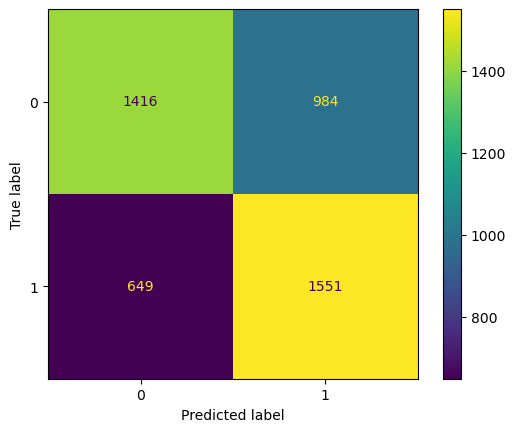

In [49]:
results_unseen = confusion_matrix(ytest_med, y_unseen_predict_med)
s_acc_u=results_unseen[1][1]/sum(results_unseen[1])
u_acc_u=results_unseen[0][0]/sum(results_unseen[0])
print('Successful Games acc: ',np.round(s_acc_u*100),'%')
print('Unsuccessful Games acc: ',np.round(u_acc_u*100),'%')
cm_display_u = ConfusionMatrixDisplay(results_unseen).plot()

# 4 - Save Trained Model

In [129]:
# save the model to disk

model_pkl = "median_358_347_307_235_221_308.pkl"  

with open(model_pkl, 'wb') as file:  
    pickle.dump(model_med, file)

Although we can see the accuracy of predictions is still relatively low, there is a huge improvement of the model's performance by training it only on the data of game sessions that were closer to the median sequence.